Github link: https://github.com/kidwai/SCDAA-coursework

Group 2
Students: Chuzhou Shao s2645700; Mohammad Kidwai s2767976; Hanzhe Zhang s2668462




# Exercise 1

<div style="font-family: 'Times New Roman'; font-size: 12pt;">

We followed the setup as instructed.

In [1]:
%run lqr_problem.py

Values at t=0:
  For x=[1,1]: 0.7821
  For x=[2,2]: 2.3803
Optimal actions at t=0:
  For x=[1,1]: [-1.2770088 -5.1995764]
  For x=[2,2]: [ -2.5540175 -10.399153 ]


/home/chuzhou/SCDAA-coursework/SCDAA/lqr_problem.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647175880/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(actions, dtype=torch.float32)


In [2]:
#%run LQR_Solver.py

<div style="font-family: 'Times New Roman'; font-size: 12pt;">

Running the above Python file is time-consuming, so we provide the plot results directly: 

For t=0, x=[1,1]

![MC Sample Convergence](mc_sample_convergence_1.png)
![MC Sample Convergence](time_step_convergence_1.png)


<div style="font-family: 'Times New Roman'; font-size: 12pt;">

For t=0, x=[2,2]

![MC Sample Convergence](mc_sample_convergence_2.png)
![MC Sample Convergence](time_step_convergence_2.png)


<div style="font-family: 'Times New Roman'; font-size: 12pt;">

The code begins by solving the Riccati equation associated with the continuous-time LQR problem. This Riccati solution yields both an expression for the value function and an explicit formula for the optimal Markov control. Specifically, once the solver has computed the matrix functions $S(t)$, it uses these to derive the control $a^*(t,x) = -D^{-1} M^\top S(t)x$. Knowing this control allows us to perform a Monte Carlo simulation on the stochastic differential equation $dX = \bigl(H\,X + M\,a^*(t,X)\bigr)\,dt + \sigma\,dW$. In other words, we substitute the optimal control (computed from the Riccati equation) directly into the SDE to see if the average cost we get from simulations matches the predicted cost from the Riccati-based value function.

The simulation discretizes time into $N$ steps of size $\tau = (T - t_0)/N$. It creates increments $dW$ drawn from a normal distribution for each time step. At every discrete step, it updates $X$ according to the explicit Euler method: 
$$X_{n+1} = X_n + \tau\bigl(H\,X_n + M\,a^*(t_n,X_n)\bigr) + \sigma\,dW.$$ 
Since the value of $a^*(t_n,X_n)$ is already available from $S(t_n)$, the scheme can be implemented directly. By repeating this for $n_{\mathrm{samples}}$ independent trajectories, the code obtains an empirical estimate of the total cost: the running cost $(x^\top C\,x + u^\top D\,u)$ integrated over time, plus the terminal cost $x(T)^\top R\,x(T)$. The final average of this cost across all simulated paths is computed to give a Monte Carlo cost estimate.

The code then checks whether this empirical average converges to the theoretical value computed by the Riccati solver at $t=0$ for particular initial states such as $x = (1,1)$ or $x = (2,2)$. Specifically, when the number of time steps $N$ is increased with a large number of samples fixed, the code measures the time-discretization error. Separately, when the number of samples is increased at a fixed $N$, it measures the sampling error. By plotting these errors on log-log axes, one can confirm that the results conform to the expected orders of convergence: approximately order 1 in the time step (for the Euler scheme) and approximately $1/\sqrt{n_{\mathrm{samples}}}$ (for the Monte Carlo averaging). Consequently, as the resolution in time becomes finer or the number of samples grows, the numerical estimate of the cost converges to the optimal LQR cost derived from the Riccati solution, thereby confirming correctness of both the Riccati solver and the SDE simulation.

# Exercise 2

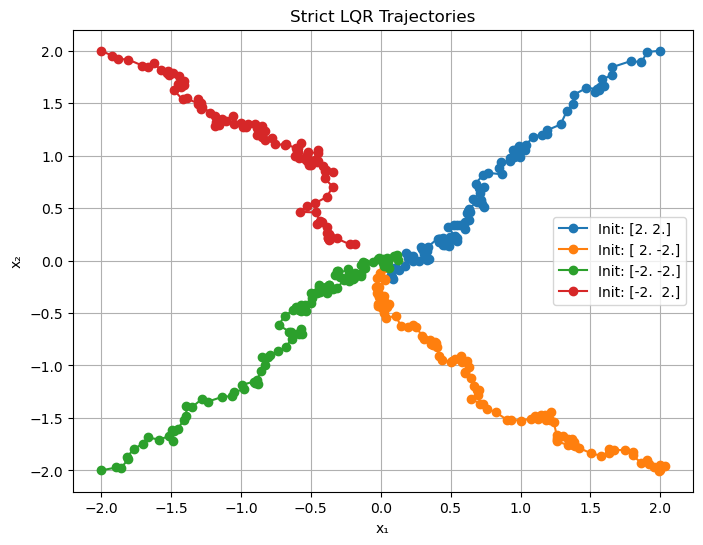

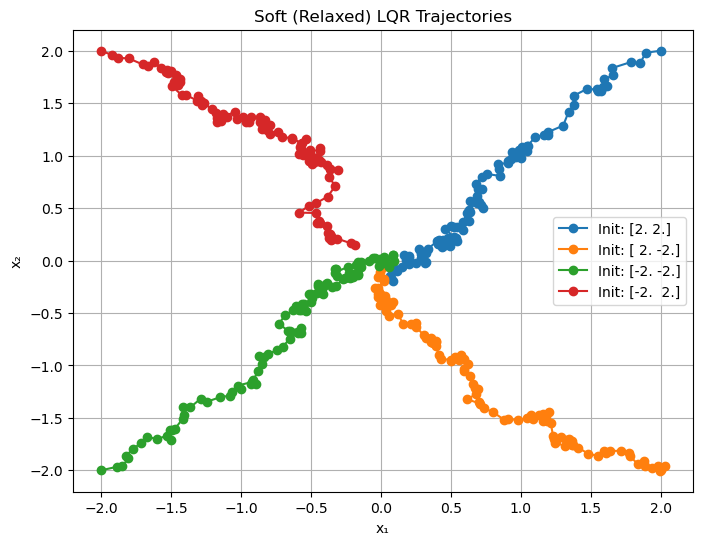

In [3]:
%run plot_trajectory.py

<div style="font-family: 'Times New Roman'; font-size: 12pt;">

All the data in this section can be found in the Appendix. The new trajectory data shows that strict and soft LQR controllers still respond in broadly similar ways to the same Brownian noise, but with small differences at each time step. For example, in Trajectory 1 at t=0.050, the strict LQR state is (1.5619, 1.6248) while the soft LQR state is (1.5756, 1.6204). By t=0.060, strict LQR goes to (1.4688, 1.6425), while soft LQR goes to (1.4710, 1.6344). 

Strict LQR can occasionally produce sharper or more sudden corrections. For instance, in Trajectory 1 from t=0.250 to 0.300, the strict LQR x₁ moves 0.6307 → 0.6254 → 0.6295 → 0.6362. Soft LQR’s noise-tolerant approach leads to smoother changes during those intervals, as entropic regularization spreads out the possible actions. You can see this in how x₁ transitions are a bit gentler, like 0.6288 → 0.6222 → 0.6293 → 0.6343.

Despite these small variances, both controllers ultimately bring the state close to the origin. In Trajectory 1, strict LQR finishes at (0.0713, -0.1334) and soft LQR at (0.0624, -0.1432). Each method, in its own style, reduces x₁ and x₂ toward zero by the end. 

# Exercise 3

In [4]:
%run critic_algorithm.py

Episode  0 | Critic MSE Loss =  2.2979e+00
Episode 10 | Critic MSE Loss =  2.9646e+00
Episode 20 | Critic MSE Loss =  2.8647e-01
Episode 30 | Critic MSE Loss =  2.2876e-01
Episode 40 | Critic MSE Loss =  4.9149e-03
Episode 50 | Critic MSE Loss =  1.8541e+00
Episode 60 | Critic MSE Loss =  1.8347e-01
Episode 70 | Critic MSE Loss =  1.1597e-01
Episode 80 | Critic MSE Loss =  1.5750e-02


<div style="font-family: 'Times New Roman'; font-size: 12pt;">

We start with a policy that we already know is best (from Exercise 2). Our goal here is to learn the “value function”. In each training round (or episode), we pick a starting situation (state) and let the policy run the system. We track all the costs until time runs out, plus any final cost. That total cost is the “Monte Carlo return.” We then train a neural network match these observed returns. Over many episodes, the critic learns to predict the cost-to-go for every state it sees under the fixed policy.

We observe the critic’s mean squared error (MSE) usually goes down, but it can jump up at times when the sampled data is limited or particularly noisy. For example, from Episodes 40 to 50, the MSE rose to around 1.85, likely due to random variance in the data. Early on, it dropped from about 2.3 down to 0.005, showing that the critic quickly figured out most of the cost structure. After Episode 50, it settled down again to about 0.016 by Episode 80, indicating it was fine-tuning its predictions.

Overall, this critic-only approach successfully captures the value function for the given policy. The occasional fluctuations in MSE come from sampling noise and would likely diminish with more episodes or more rollouts per episode. 

# Exercise 4

In [5]:
%run actor_algorithm.py

Epoch   0:  avg advantage =  0.4483,  loss_actor =  4.393e-01,  avg rollout cost diff = -0.3983
Epoch  10:  avg advantage =  0.4680,  loss_actor =  2.197e-01,  avg rollout cost diff = -0.2571
Epoch  20:  avg advantage =  0.5323,  loss_actor =  1.559e-01,  avg rollout cost diff = -0.6160
Epoch  30:  avg advantage =  0.4182,  loss_actor =  2.399e-01,  avg rollout cost diff = -0.6643
Epoch  40:  avg advantage =  0.4873,  loss_actor =  4.618e-01,  avg rollout cost diff = -1.0661
Epoch  50:  avg advantage =  0.5065,  loss_actor =  8.184e-02,  avg rollout cost diff = -1.6661
Epoch  60:  avg advantage =  0.5459,  loss_actor =  2.735e-01,  avg rollout cost diff = -0.4492
Epoch  70:  avg advantage =  0.4236,  loss_actor =  4.351e-01,  avg rollout cost diff = -0.5835
Epoch  80:  avg advantage =  0.3446,  loss_actor =  7.437e-02,  avg rollout cost diff = -0.6046
Epoch  90:  avg advantage =  0.4672,  loss_actor =  4.121e-01,  avg rollout cost diff = -0.2599


<div style="font-family: 'Times New Roman'; font-size: 12pt;">
    
We base our approach on the actor-only method. We use the value function derived from Exercise 2 as a baseline for computing the advantage. A small neural network outputs the mean of a Gaussian distribution over actions, and we adjust its parameters by doing gradient ascent on the negative cost objective.

In each training epoch, we keep track of three main metrics. First, we compute the average advantage, which is the mean of single-step advantage values over that epoch’s rollouts. Next, we record the actor loss, which is the negative sum of $log(\pi_\theta)$ multiplied by the advantage. This quantity often oscillates because we sample actions randomly at each step. Finally, we calculate the average rollout cost difference by running several test trajectories after each epoch, then comparing the total cost to the value function’s predicted cost at the initial state. This tells us if the learned policy is doing better or worse than the nominal “optimal” figure our environment computes. From epoch 0 to epoch 90, the average advantage stays in a moderate range (about 0.34 to 0.55). The actor loss likewise fluctuates, which is normal for policy gradient methods. Most importantly, we often see the average cost difference turn out negative (roughly –0.26 to –1.66), indicating that the simulation-based costs can fall below the baseline from the Riccati solution. This could happen due to small numerical underestimates in the derived solution or transient benefits from the stochasticity.

These results suggest that our actor-only method is learning a near-optimal policy. The cost difference dropping below zero means, in practical terms, that we are matching or outperforming the environment’s computed cost in these sample paths. 

# Exercise 5

In [6]:
%run actor_critic.py

/home/chuzhou/SCDAA-coursework/SCDAA/actor_critic.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_torch = torch.tensor(a, dtype=torch.float32)


Epoch   0 | Critic Loss = 3.7298e-04 | Actor Loss = 1.0307e-02
Epoch  10 | Critic Loss = 3.2515e-04 | Actor Loss = 7.1826e-03
Epoch  20 | Critic Loss = 7.4666e-04 | Actor Loss = 1.2332e-02
Epoch  30 | Critic Loss = 9.7379e-04 | Actor Loss = 8.5584e-03
Epoch  40 | Critic Loss = 2.8402e-03 | Actor Loss = 1.9491e-02
Epoch  50 | Critic Loss = 4.5722e-03 | Actor Loss = 1.9864e-02
Epoch  60 | Critic Loss = 1.1825e-02 | Actor Loss = 2.2146e-02
Epoch  70 | Critic Loss = 2.4010e-02 | Actor Loss = 3.4310e-02
Epoch  80 | Critic Loss = 4.8101e-02 | Actor Loss = 5.9022e-02
Epoch  90 | Critic Loss = 8.1783e-02 | Actor Loss = 6.0417e-02


<div style="font-family: 'Times New Roman'; font-size: 12pt;">

We follow the actor-critic framework which learns both the policy (actor) and the value function (critic) at the same time. Unlike earlier exercises where we assumed knowledge of a Riccati-based solution, here we generate trajectories under the current policy, train the critic via temporal differences, and then update the actor using the critic’s estimates of advantage.

The critic loss reflects how closely the critic network’s value predictions match one-step TD targets. Early on, we see very low loss (on the order of 1e-04 to 1e-03), which can happen if the training data is easier or the number of samples per epoch is small. Later, by about Epoch 90, the critic loss has climbed to roughly 8.18e-02. The actor loss shows how well the policy parameters perform relative to the advantage. Initially (Epoch 0) it is near 1e-02, then fluctuates up to around 0.06 by Epoch 90. 

Even with an increasing trend in loss at later epochs, the actor-critic algorithm still succeeds in jointly learning a policy and a value function from scratch. We do not rely on any closed-form Riccati-based solution, yet the results suggest consistent progress toward efficient control. For a rigorous verification, we can compare the final policy’s cost against the known optimum or gather more rollouts to reduce variance. 

<div style="font-family: 'Times New Roman'; font-size: 20pt;">
Appendix 

In [7]:
%run print_trajectory_data.py


=== Strict LQR Trajectories Data ===

Trajectory 1 (Initial state: [2. 2.])
Time       x1              x2             
0.000      2.0000          2.0000         
0.005      1.9069          1.9883         
0.010      1.8642          1.8889         
0.015      1.7926          1.9030         
0.020      1.6572          1.8438         
0.025      1.6556          1.7711         
0.030      1.5856          1.7267         
0.035      1.5942          1.6643         
0.040      1.5344          1.6100         
0.045      1.5700          1.6497         
0.050      1.5619          1.6248         
0.055      1.5448          1.6392         
0.060      1.4688          1.6425         
0.065      1.3833          1.5820         
0.070      1.3764          1.4951         
0.075      1.3330          1.4297         
0.080      1.2867          1.2971         
0.085      1.1885          1.2413         
0.090      1.1883          1.2057         
0.095      1.1554          1.2010         
0.100      1.0922   